In [1]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.spatial import distance

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import (
    MinMaxScaler, Normalizer, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler)

from yellowbrick.cluster import InterclusterDistance


In [2]:
features = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", \
            "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", \
            "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", \
            "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", \
            "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack_cat"]

In [3]:
df = pd.read_csv("../data/kdd/kddcup.data_10_percent_corrected.csv", names=features)

df.head(1)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_cat
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.


### PREPROCESSING

In [4]:
# encode categorical features
le = preprocessing.LabelEncoder()
df['protocol_type'] = le.fit_transform(df['protocol_type'])
df['service'] = le.fit_transform(df['service'])
df['flag'] = le.fit_transform(df['flag'])

df.head(1)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_cat
0,0,1,22,9,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.


In [5]:
# separate features from labels
X = df.drop('attack_cat', axis=1)
X.columns = X.iloc[0]

y = le.fit_transform(df['attack_cat'])

y_label_map = dict(zip(le.classes_, le.transform(le.classes_)))

X.shape, y.shape


((494021, 41), (494021,))

In [6]:
# scale data using different scalers and compare

# data normalizer
scaler = Normalizer().fit(X)
X_normalizer = scaler.transform(X)

# min-madf scaler
scaler = MinMaxScaler().fit(X)
X_minmax = scaler.transform(X)

# robust scaler
scaler = RobustScaler().fit(X)
X_robust = scaler.transform(X)

# standard scaler
scaler = StandardScaler().fit(X)
X_standard = scaler.transform(X)

# quantile transformer
scaler = QuantileTransformer().fit(X)
X_quantile = scaler.transform(X)

# power transformer
scaler = PowerTransformer().fit(X)
X_power = scaler.transform(X)


In [7]:
# measure nearest shrunken centroid
def nearest_shrunken_centroid(X, y):
    clf = NearestCentroid(shrink_threshold=0.1)
    clf.fit(X, y)

    return clf.centroids_


In [8]:
# compute  Mahalanobis distance between the class centroids
def mahalanobis_distance(X, y):
    centroids = nearest_shrunken_centroid(X, y)
    distances = np.zeros((len(centroids), len(centroids)))

    for i in range(centroids.shape[0]):
        for j in range(centroids.shape[0]):
            if i != j:
                distances[i, j] = distance.mahalanobis(centroids[i], centroids[j], np.cov(X, rowvar=False))

    return distances


In [9]:
# compute the distance for unscaled data and each scaler's output

# unscaled data
distances = mahalanobis_distance(X, y)

# normalizer
distances_normalizer = mahalanobis_distance(X_normalizer, y)

# min-madf scaler
distances_minmax = mahalanobis_distance(X_minmax, y)

# robust scaler
distances_robust = mahalanobis_distance(X_robust, y)

# standard scaler
distances_standard = mahalanobis_distance(X_standard, y)

# quantile transformer
distances_quantile = mahalanobis_distance(X_quantile, y)

# power transformer
distances_power = mahalanobis_distance(X_power, y)


In [10]:
def clean_plot(ax=None):
    if ax is None:
        ax = plt.gca()

    # remove tick params
    ax.tick_params(axis=u'both', which=u'both', length=0)

    # remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)

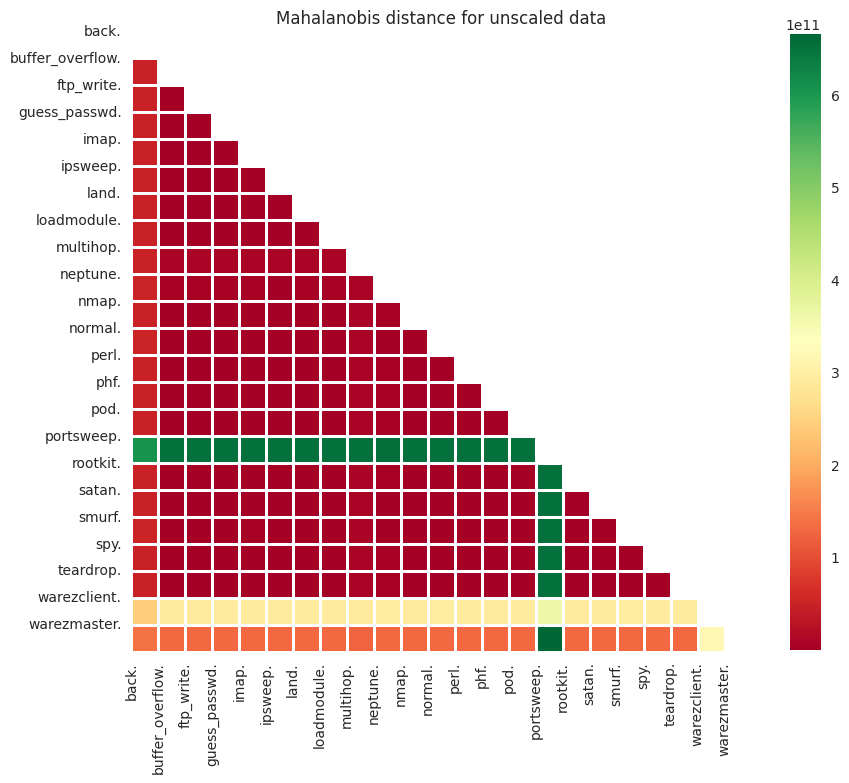

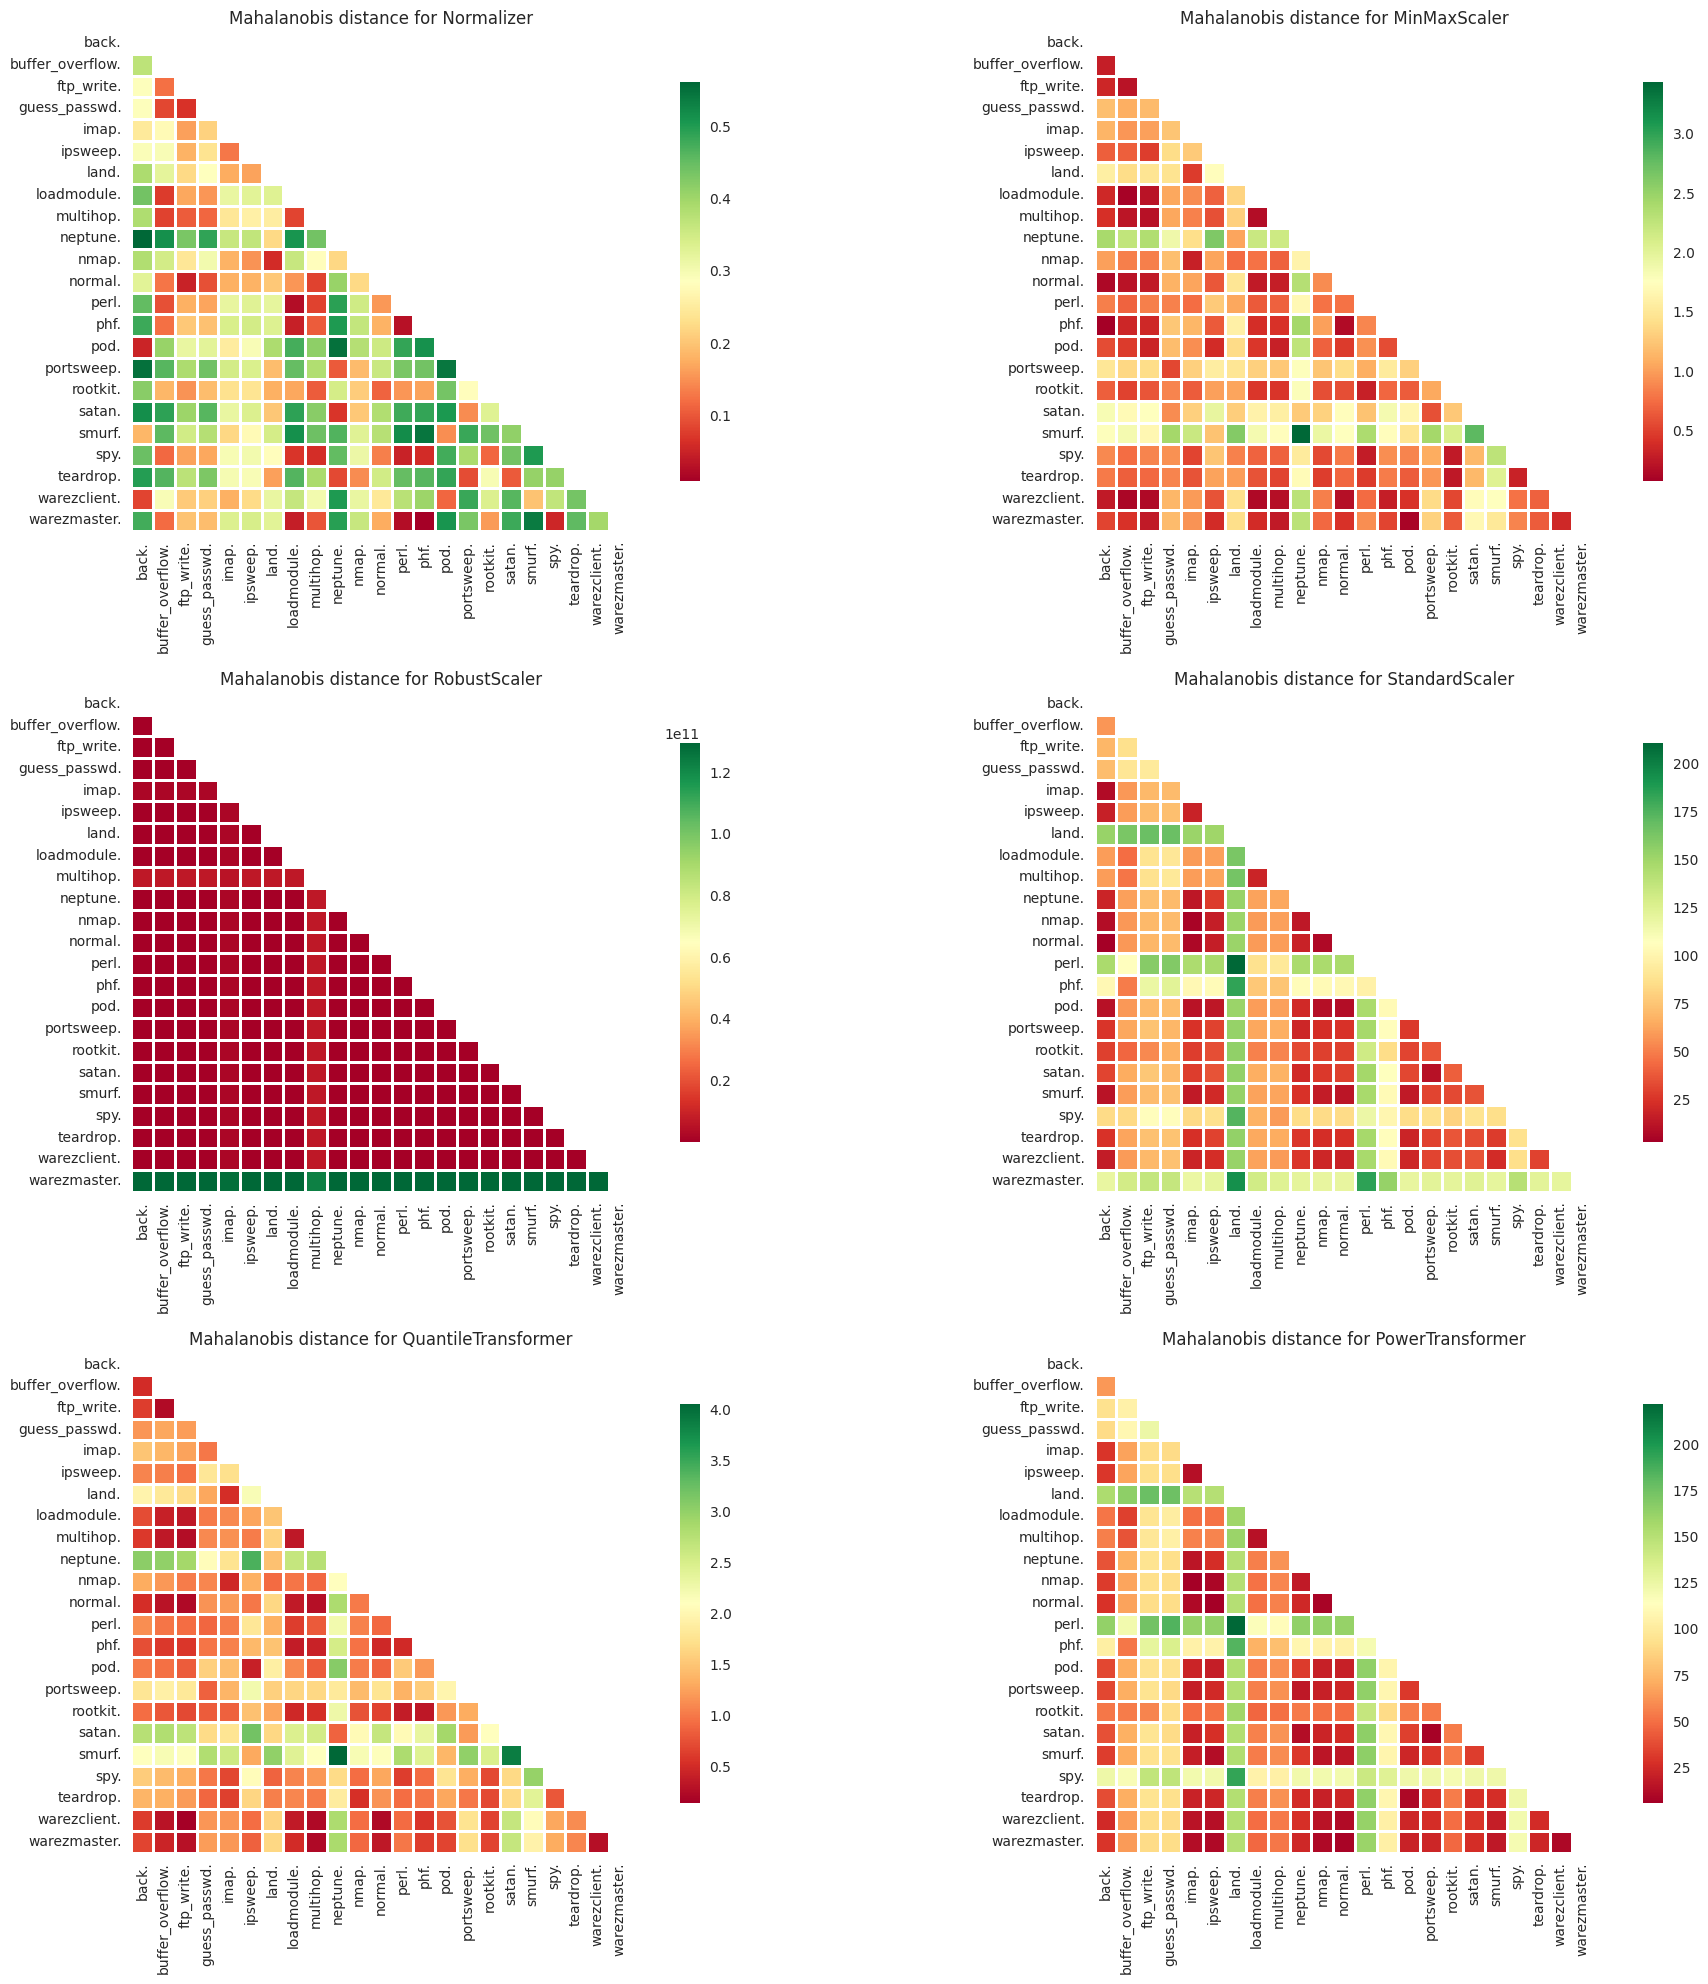

In [15]:
# plot heatmap for each set of distances

# create a boolean mask to remove redundant values from the plot
mask = np.zeros_like(distances)
mask[np.triu_indices_from(mask)] = True


def heatmap(data, ax=None, title=''):
    sns.heatmap(data, cmap='RdYlGn', mask=mask, ax=ax, linewidths=2, cbar_kws={'shrink': .8}, square=True)
    if ax:
        ax.set_title(title)
        ax.set_xticklabels(y_label_map.keys(), rotation=90)
        ax.set_yticklabels(y_label_map.keys(), rotation=0)


# unscaled data
plt.figure(figsize=(10, 10))
heatmap(distances)
plt.title('Mahalanobis distance for unscaled data')
plt.xticks(range(len(y_label_map)), y_label_map.keys(), rotation=90)
plt.yticks(range(len(y_label_map)), y_label_map.keys(), rotation=0)
plt.show()

# scaled data
fig, axis = plt.subplots(3, 2, figsize=(20, 20))

# normalizer
heatmap(distances_normalizer, ax=axis[0, 0], title='Mahalanobis distance for Normalizer')

# min-max
heatmap(distances_minmax, ax=axis[0, 1], title='Mahalanobis distance for MinMaxScaler')

# robust
heatmap(distances_robust, ax=axis[1, 0], title='Mahalanobis distance for RobustScaler')

# standard
heatmap(distances_standard, ax=axis[1, 1], title='Mahalanobis distance for StandardScaler')

# quantile
heatmap(distances_quantile, ax=axis[2, 0], title='Mahalanobis distance for QuantileTransformer')

# power
heatmap(distances_power, ax=axis[2, 1], title='Mahalanobis distance for PowerTransformer')

fig.tight_layout()
plt.show()


In [17]:
# apply ElasticNetCV on the min-max output 5 times with cross-validation and calculate MSE

model = ElasticNetCV(cv=5, random_state=0)
model.fit(X_normalizer, y)


ElasticNetCV(cv=5, random_state=0)

In [18]:
alpha = model.alpha_
alphas = model.alphas_
mse = model.mse_path_
alphas_path, coef, _ = model.path(X_normalizer, y)


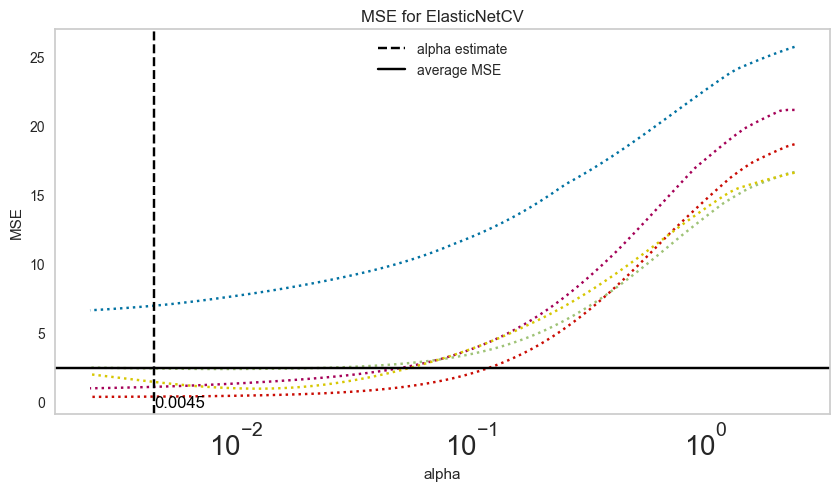

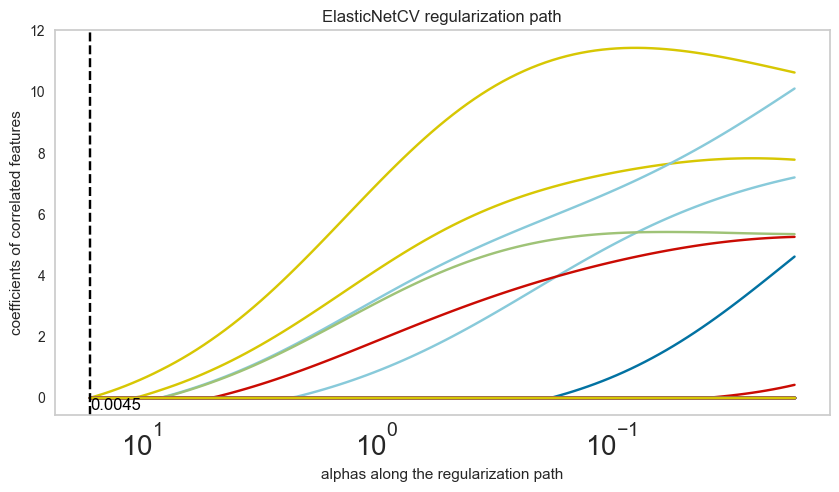

In [25]:
# plot the results

# mse plot with final alpha and mse highlighted
plt.figure(figsize=(10, 5))
plt.semilogx(alphas, mse)
plt.setp(plt.gca().get_lines(), linestyle=':')
plt.title('MSE for ElasticNetCV')
plt.axvline(alpha, color='black', label='alpha estimate', linestyle='--')
plt.axhline(mse.mean(axis=1).min(), color='black', label='average MSE')
plt.text(alpha, -.4, '{:.4f}'.format(alpha), {'color': 'black', 'fontsize': 12})

plt.legend()
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.grid(None)
plt.show()

# plot the regularization path for elastic net presenting the informative features
plt.figure(figsize=(10, 5))
plt.title('ElasticNetCV regularization path')
plt.semilogx(alphas_path, coef.T)
plt.axvline((np.max(alphas_path) - alpha), color='black', linestyle='--')
plt.text((np.max(alphas_path) - alpha), -0.4, '{:.4f}'.format(alpha),
         {'color': 'black', 'fontsize': 12})

plt.gca().invert_xaxis() # rectify plot direction
plt.xlabel('alphas along the regularization path')
plt.ylabel('coefficients of correlated features')
plt.grid(None)
plt.show()


In [27]:
# display the list of features selected by Elastic Net as a table
selected_features_idx = np.where(model.coef_ != 0)
selected_features = pd.DataFrame({'feature': df.columns[selected_features_idx], 'coefficient': model.coef_[selected_features_idx]})
selected_features = selected_features[selected_features.coefficient != 0].sort_values('coefficient')
selected_features = selected_features.reset_index(drop=True)

selected_features

,feature,coefficient
0,service,-1.596316
1,dst_host_count,-1.454654
2,dst_bytes,0.007270
3,count,0.129767
4,dst_host_srv_count,0.300835
5,duration,0.475803
6,src_bytes,3.097777
7,srv_count,13.018651


### VISUALIZATION

In [28]:
# stratified sampling - take 20% of the data for each class

_, X_normalizer_sample, _, y_sample = train_test_split(X_normalizer, y, test_size=0.2, stratify=y, random_state=0)

X_normalizer_sample = pd.DataFrame(X_normalizer_sample)

inv_y_label_map = {v: k for k, v in y_label_map.items()}
counts = X_normalizer_sample.groupby(y_sample).count().iloc[:, :1].rename(columns={0: 'count'}, index=inv_y_label_map)
distribution = (counts / counts.sum() * 100).rename(columns={'count': 'distribution'})

class_dist = pd.merge(counts, distribution, left_index=True, right_index=True).sort_values('count', ascending=False)

class_dist

,count,distribution
smurf.,56158,56.837205
neptune.,21440,21.699307
normal.,19456,19.691311
back.,441,0.446334
satan.,318,0.321846
ipsweep.,249,0.252012
portsweep.,208,0.210516
warezclient.,204,0.206467
teardrop.,196,0.198371
pod.,53,0.053641


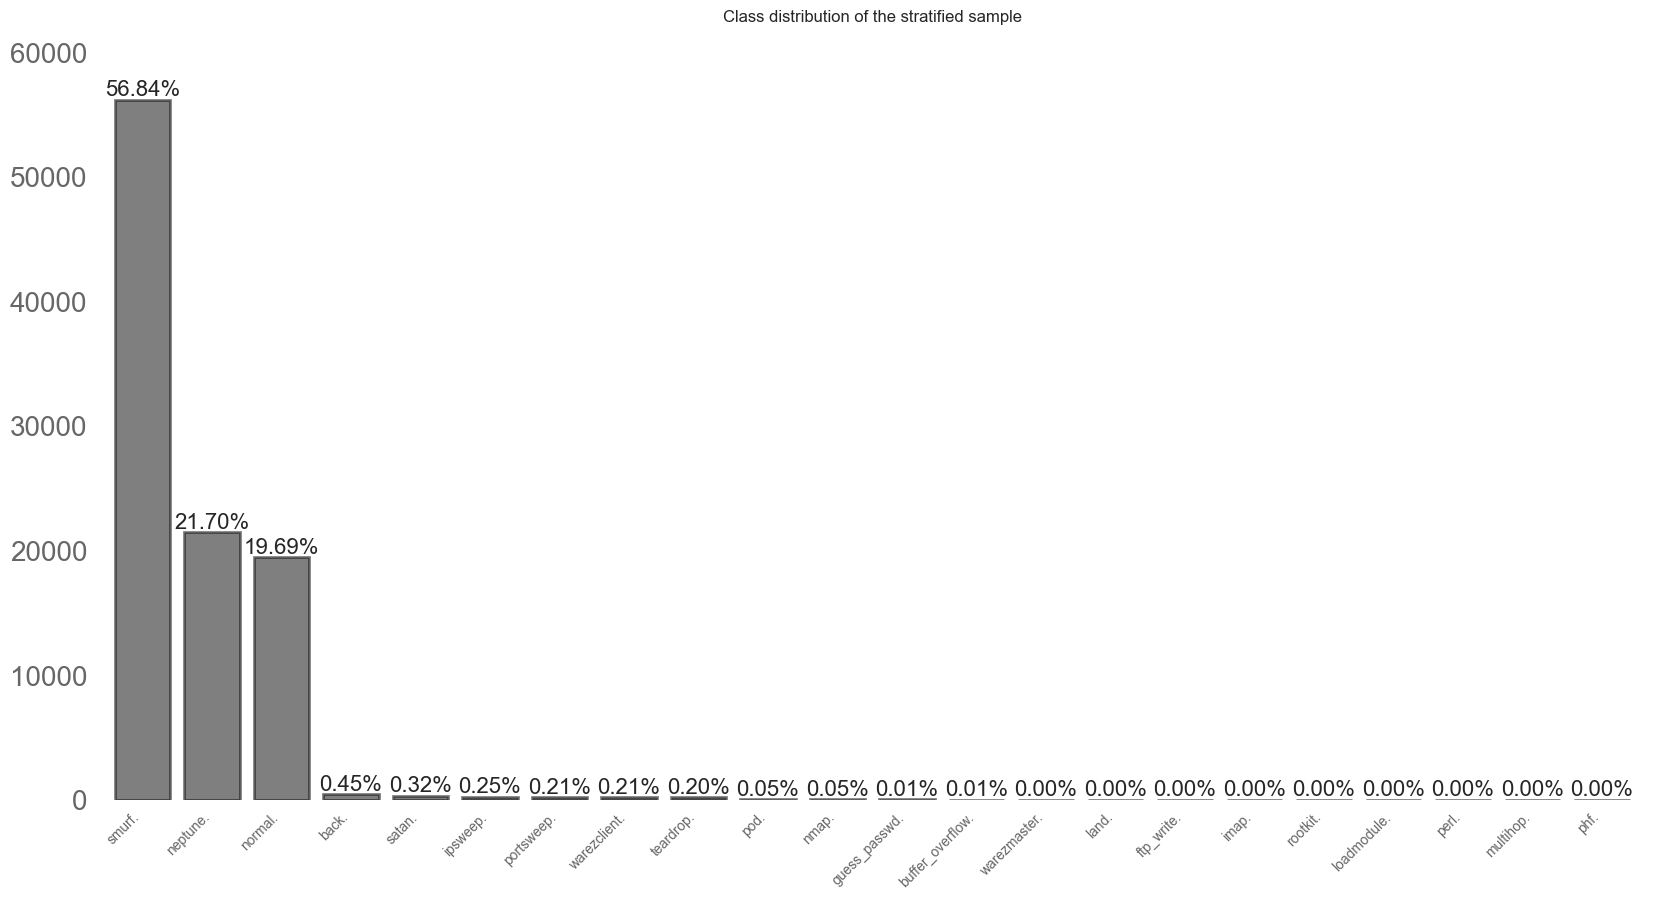

In [31]:
# plot the class distribution of the stratified sample

labels = [f'{dist:.2f}%' for dist in class_dist.distribution]

ax = class_dist['count'].plot(kind='bar',  figsize=(20, 10), rot=0, width=0.8, color='black', edgecolor='black', lw=2, alpha=0.5, label='count', title='Class distribution of the stratified sample')
ax.bar_label(ax.containers[0], labels=labels, label_type='edge', fontsize=16)
ax.margins(y=0.1)

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=20)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', alpha=0.7)
plt.setp(ax.get_yticklabels(), alpha=0.7)

clean_plot()
plt.grid(None)
plt.show()

In [87]:
# PCA

pca = PCA(n_components=3, random_state=0)

# fit PCA model
pca.fit(X_normalizer_sample)

# transform X_normalizer_sample to PCA space
X_normalizer_sample_transformed = pca.transform(X_normalizer_sample)

X_normalizer_sample_transformed_df = pd.DataFrame(X_normalizer_sample_transformed, columns=['PC1', 'PC2', 'PC3'])

X_normalizer_sample_transformed_df

,PC1,PC2,PC3
0,-0.377079,-0.064105,-0.012446
1,-0.377079,-0.064105,-0.012446
2,-0.377079,-0.064105,-0.012446
3,0.753614,-0.209766,0.277085
4,0.406281,0.939871,-0.132593
...,...,...,...
98800,0.623673,-0.380739,-0.134267
98801,0.767811,-0.167331,0.315356
98802,0.667683,-0.371708,-0.093248
98803,0.423361,0.229261,0.452300


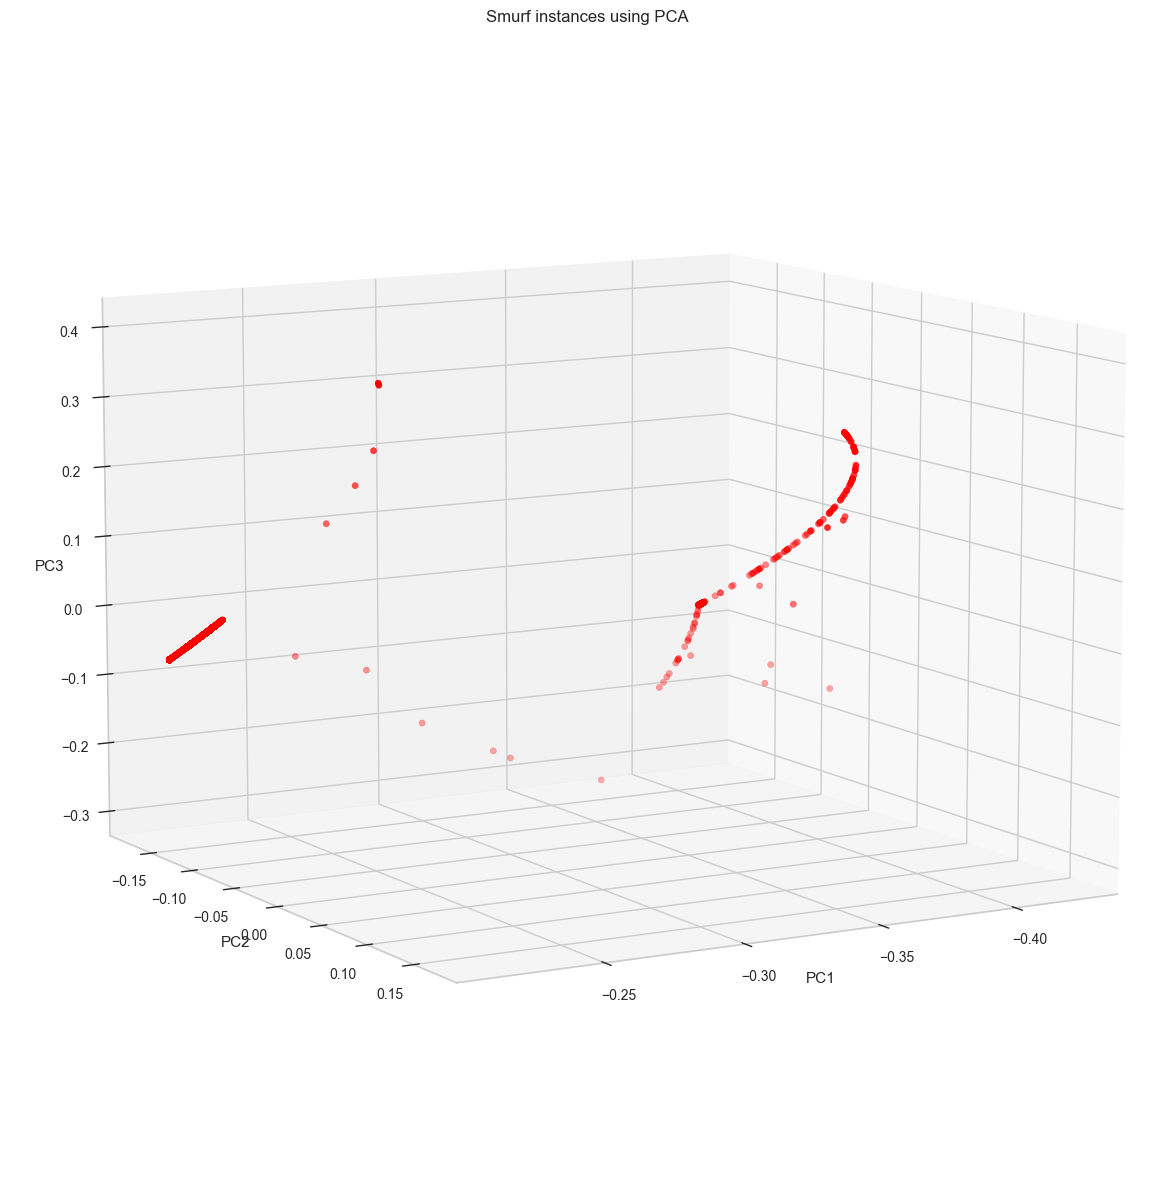

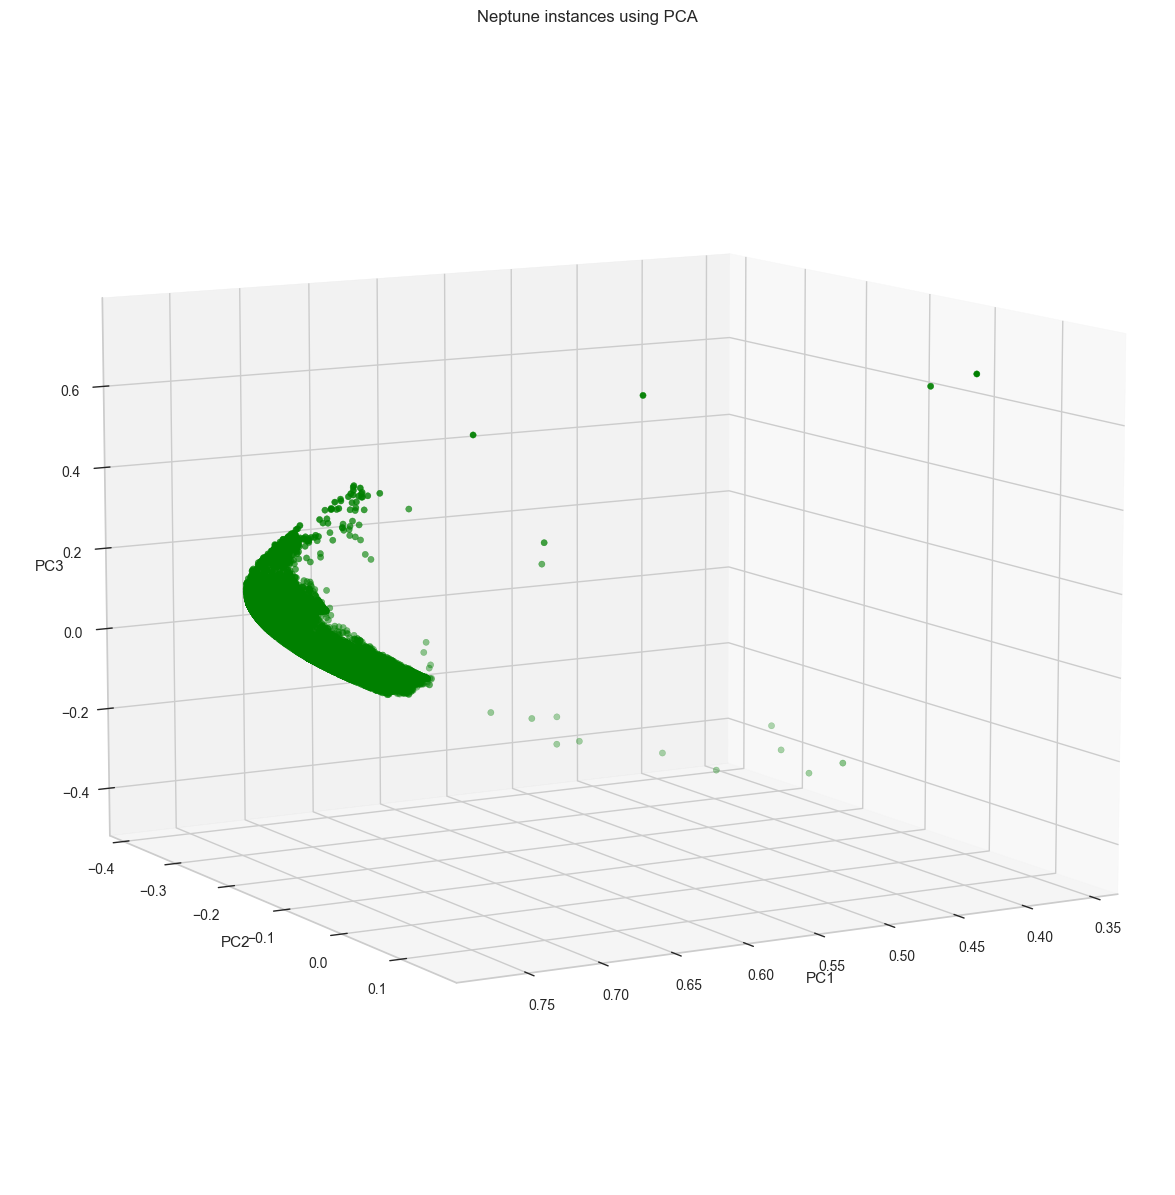

In [194]:
# visualize the within-class immbalance in the PCA space using 3D scatter plots

# visualize smurf instances using PCA
exploit = X_normalizer_sample_transformed_df[y_sample == y_label_map['smurf.']]
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(exploit.PC1, exploit.PC2, exploit.PC3, c='red', marker='o', label='Smurf')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Smurf instances using PCA')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.view_init(10, 60, 0)

clean_plot(ax)

plt.show()

#visualize neptune instances using PCA
worms = X_normalizer_sample_transformed_df[y_sample == y_label_map['neptune.']]
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(worms.PC1, worms.PC2, worms.PC3, c='green', marker='o', label='Neptune')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Neptune instances using PCA')
ax.view_init(10, 60, 0)

clean_plot(ax)

plt.show()

In [79]:
# visualize the dataset using t-SNE

tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000, verbose=1, n_jobs=-1, learning_rate='auto', angle=0.5, init='pca')
X_normalizer_sample_transformed = tsne.fit_transform(X_normalizer_sample)

X_normalizer_sample_transformed_df_tsne = pd.DataFrame(X_normalizer_sample_transformed, columns=['TSNE1', 'TSNE2'])

X_normalizer_sample_transformed_df_tsne

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 98805 samples in 0.008s...
[t-SNE] Computed neighbors for 98805 samples in 45.413s...
[t-SNE] Computed conditional probabilities for sample 1000 / 98805
[t-SNE] Computed conditional probabilities for sample 2000 / 98805
[t-SNE] Computed conditional probabilities for sample 3000 / 98805
[t-SNE] Computed conditional probabilities for sample 4000 / 98805
[t-SNE] Computed conditional probabilities for sample 5000 / 98805
[t-SNE] Computed conditional probabilities for sample 6000 / 98805
[t-SNE] Computed conditional probabilities for sample 7000 / 98805
[t-SNE] Computed conditional probabilities for sample 8000 / 98805
[t-SNE] Computed conditional probabilities for sample 9000 / 98805
[t-SNE] Computed conditional probabilities for sample 10000 / 98805
[t-SNE] Computed conditional probabilities for sample 11000 / 98805
[t-SNE] Computed conditional probabilities for sample 12000 / 98805
[t-SNE] Computed conditional probabilities for sa

C:\Users\karti\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 127.869629
[t-SNE] KL divergence after 1000 iterations: 2.994607


,TSNE1,TSNE2
0,-69.798073,26.670406
1,-253.807770,-67.435837
2,328.208496,547.972656
3,85.319656,43.365536
4,1.220315,109.199257
...,...,...
98800,28.073023,-63.312576
98801,76.529228,27.633852
98802,53.522549,-89.022575
98803,55.396351,54.016708


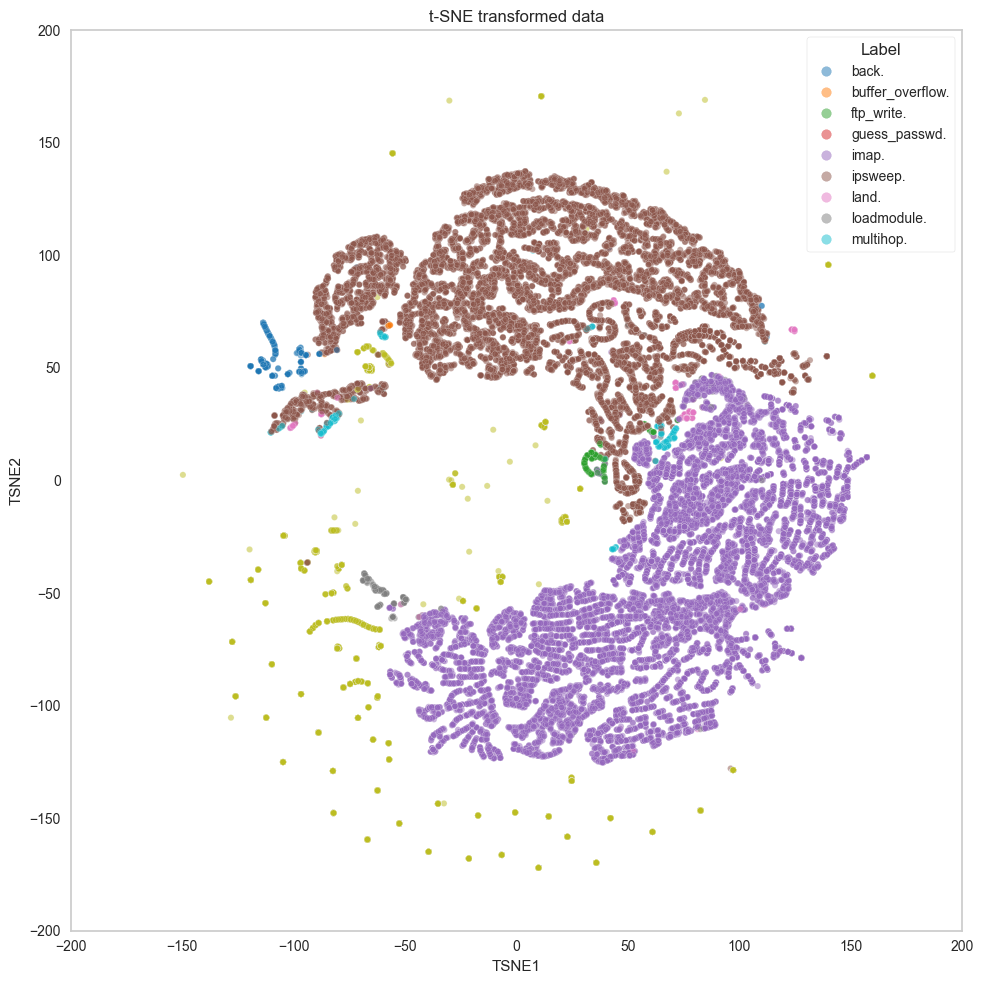

In [196]:
# plot a 2D scatter-plot of the t-SNE transformed data

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
scatter = ax.scatter(
    X_normalizer_sample_transformed_df_tsne.TSNE1, X_normalizer_sample_transformed_df_tsne.TSNE2, 
    c=y_sample, cmap='tab10', alpha=0.5, s=20, edgecolor='white', lw=0.2
)
ax.set_xlabel('TSNE1')
ax.set_ylabel('TSNE2')
ax.set_title('t-SNE transformed data')
ax.legend(handles=scatter.legend_elements()[0], labels=y_label_map, loc='upper right', frameon=True, title='Label')
ax.set_xlim(-200, 200)
ax.set_ylim(-200, 200)
ax.grid(False)

plt.tight_layout()
plt.show()

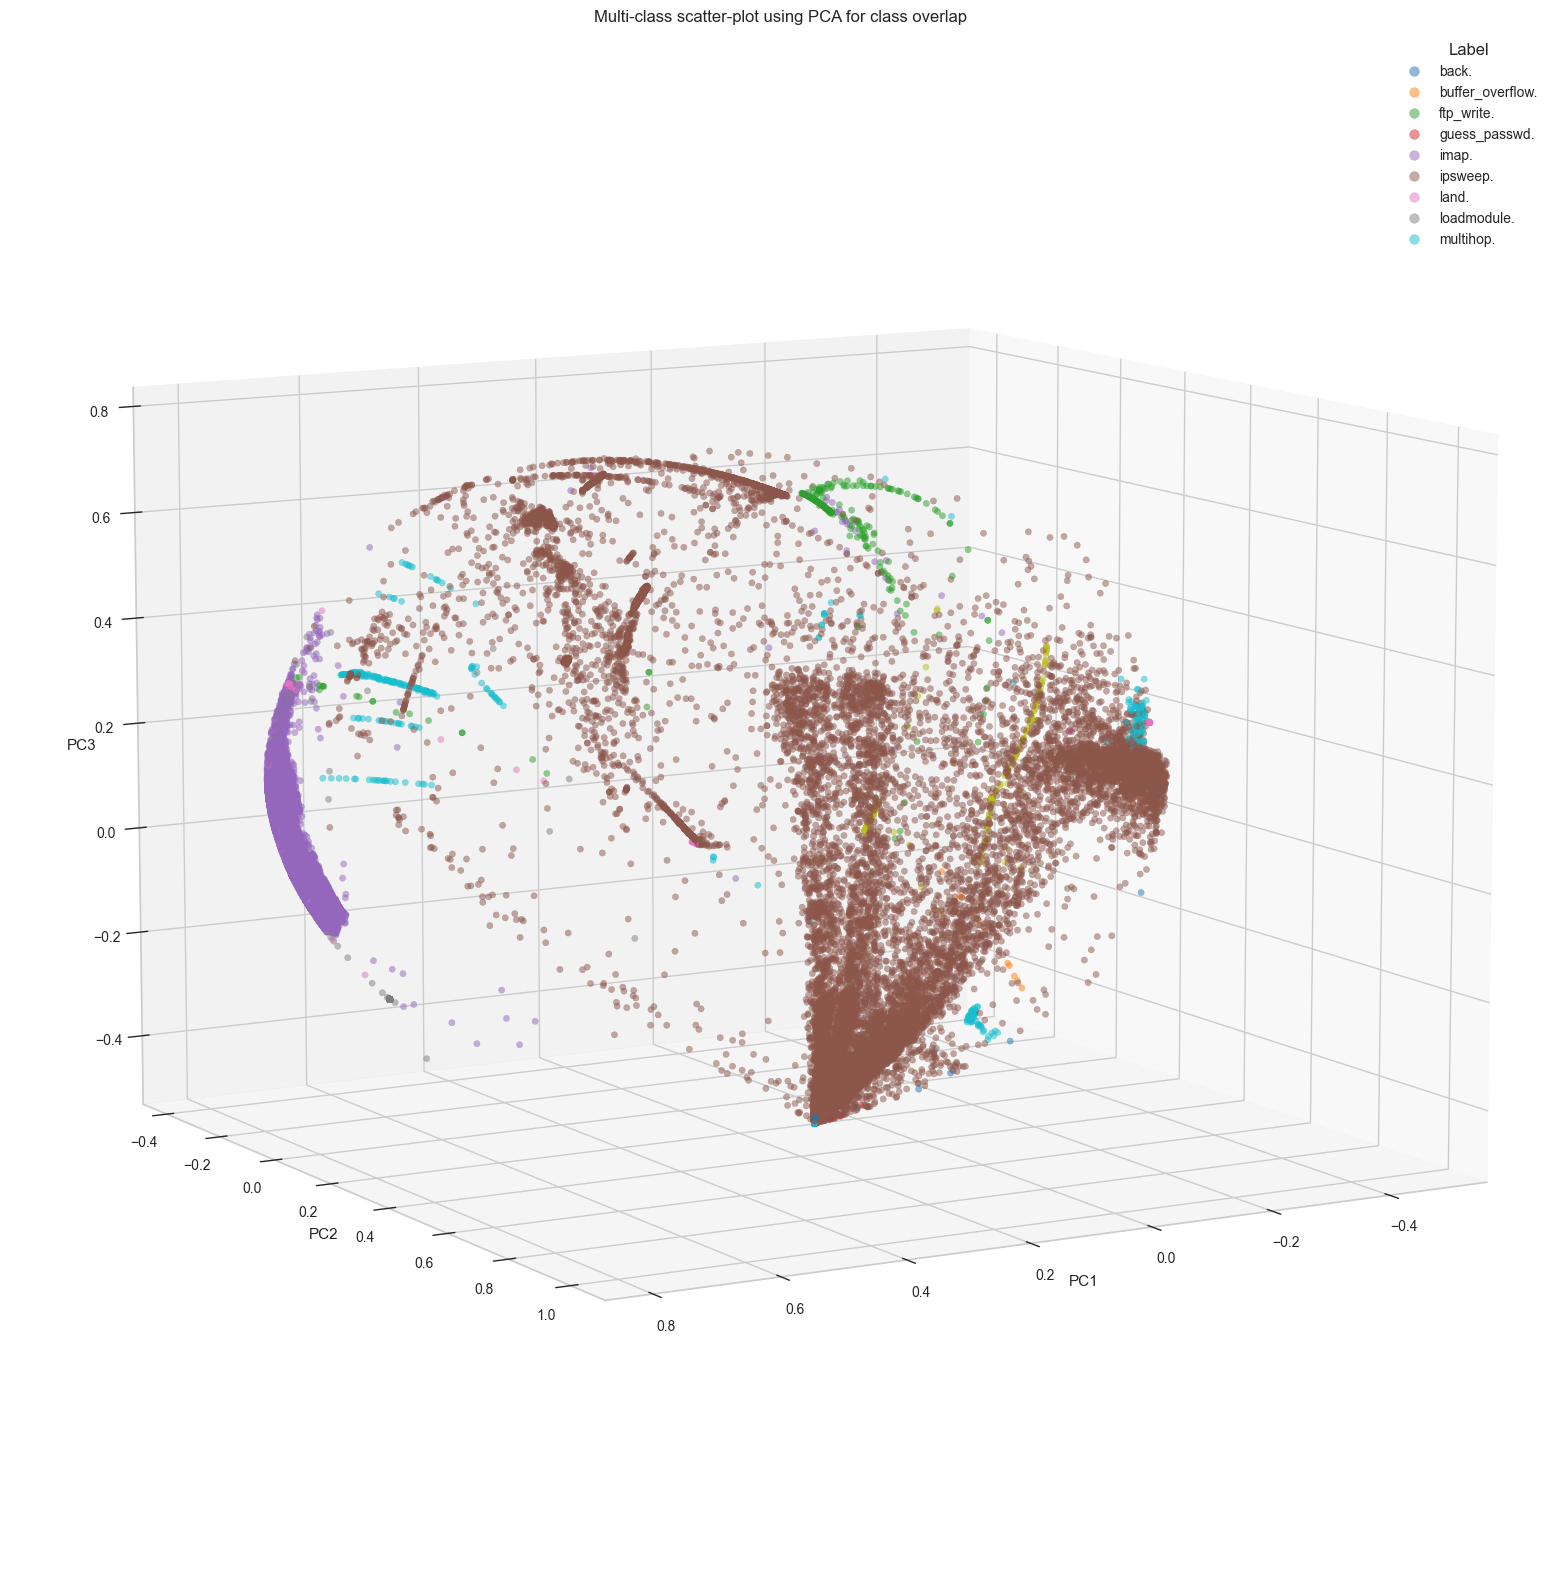

In [192]:
# plot multi-class PCA 3D scatter-plot for class overlap

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_normalizer_sample_transformed_df.PC1, X_normalizer_sample_transformed_df.PC2, 
    X_normalizer_sample_transformed_df.PC3, y_sample, 
    c=y_sample, cmap='tab10', alpha=0.5, s=20, marker='o'
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Multi-class scatter-plot using PCA for class overlap')
ax.legend(handles = scatter.legend_elements()[0], labels=y_label_map, loc='upper right', title='Label')
ax.view_init(10, 60, 0)

clean_plot(ax)

plt.show()

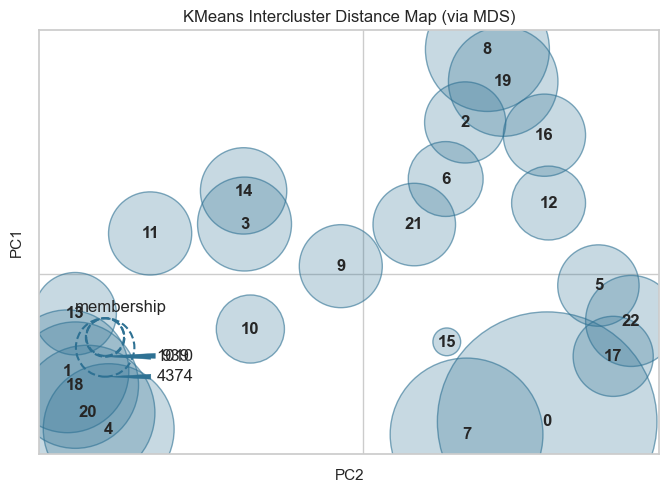

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [185]:
# plot Inter-Cluster Distance using K-Means on PCA transformed data

kmeans = KMeans(n_clusters=len(y_label_map), n_init=10, max_iter=300)
icd = InterclusterDistance(kmeans)

icd.fit(X_normalizer_sample_transformed_df)
icd.show()